In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

In [2]:
dataset = 'cityscapes'
annot_dir = './cityscapes/annotations'
imgs_dir = './cityscapes'

for split in ['train', 'val']: 
    annot_path = os.path.join(annot_dir, f'instancesonly_filtered_gtFine_{split}.json')
    d_name = dataset + f'_{split}'
    register_coco_instances(d_name, {}, annot_path, imgs_dir)

# Load dataset
dataset_dicts = DatasetCatalog.get('cityscapes_train')
metadata = MetadataCatalog.get('cityscapes_val')

[03/20 14:03:22 d2.data.datasets.coco]: Loading ./cityscapes/annotations/instancesonly_filtered_gtFine_train.json takes 2.39 seconds.
[03/20 14:03:22 d2.data.datasets.coco]: Loaded 2975 images in COCO format from ./cityscapes/annotations/instancesonly_filtered_gtFine_train.json


In [3]:
import argparse

class Args(argparse.Namespace):
    config_file='detectron2/detectron2/model_zoo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.py'
    eval_only=False
    num_gpus=1
    num_machines=1
    resume=False

args = Args()

In [4]:
from detectron2.model_zoo import get_config
from detectron2.config import LazyConfig
from detectron2.config.instantiate import instantiate


cfg = LazyConfig.load("detectron2/detectron2/model_zoo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.py")
cfg.train.device = 'mps'
cfg.dataloader.evaluator.dataset_name = 'cityscapes_val'
cfg.dataloader.train.dataset.names = 'cityscapes_train'
cfg.dataloader.test.dataset.names = 'cityscapes_val'
cfg.dataloader.train.total_batch_size = 2

In [5]:
from detectron2.checkpoint import DetectionCheckpointer

mask_rcnn = instantiate(cfg.model)
mask_rcnn.training = False
DetectionCheckpointer(mask_rcnn).load(cfg.train.init_checkpoint)

[03/20 14:03:23 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://ImageNetPretrained/MSRA/R-50.pkl ...
[03/20 14:03:23 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[03/20 14:03:23 d2.checkpoint.c2_model_loading]: Following weights matched with submodule model - Total num: 54


Some model parameters or buffers are not found in the checkpoint:
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  fc1000.{bias, weight}
  stem.conv1.bias


{'__author__': 'Caffe2', 'matching_heuristics': True}

In [6]:
mask_rcnn

GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
      )
      (1): BottleneckBlock(

In [7]:
dataloader = instantiate(cfg.dataloader.train)

[03/20 14:03:30 d2.data.datasets.coco]: Loading ./cityscapes/annotations/instancesonly_filtered_gtFine_train.json takes 5.18 seconds.
[03/20 14:03:30 d2.data.datasets.coco]: Loaded 2975 images in COCO format from ./cityscapes/annotations/instancesonly_filtered_gtFine_train.json
[03/20 14:03:30 d2.data.build]: Removed 10 images with no usable annotations. 2965 images left.
[03/20 14:03:30 d2.data.build]: Distribution of instances among all 8 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   person   | 17395        |    car     | 26180        |   truck    | 466          |
|   rider    | 1660         | motorcycle | 705          |  bicycle   | 3433         |
|    bus     | 350          |   train    | 158          |            |              |
|   total    | 50347        |            |              |            |              |
[03/20 14:03:30 d2.data.dat

In [8]:
batch = next(iter(dataloader))
first_input = batch[0]

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch


image = first_input['image']
image = image.permute(1, 2, 0)
image = np.ascontiguousarray(image, dtype=np.uint8)[..., ::-1]

# Show mask

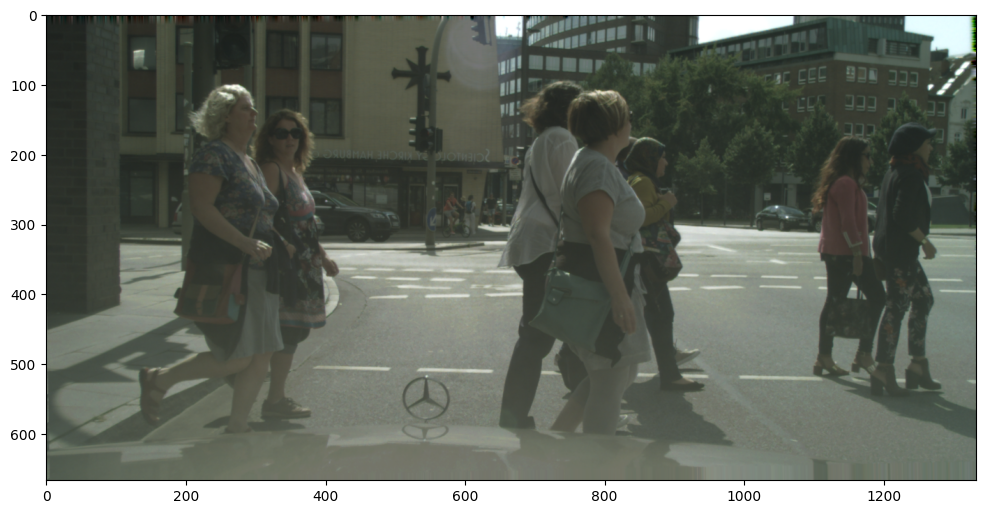

In [10]:
fig = plt.figure(figsize=(12, 12))

plt.imshow(image)

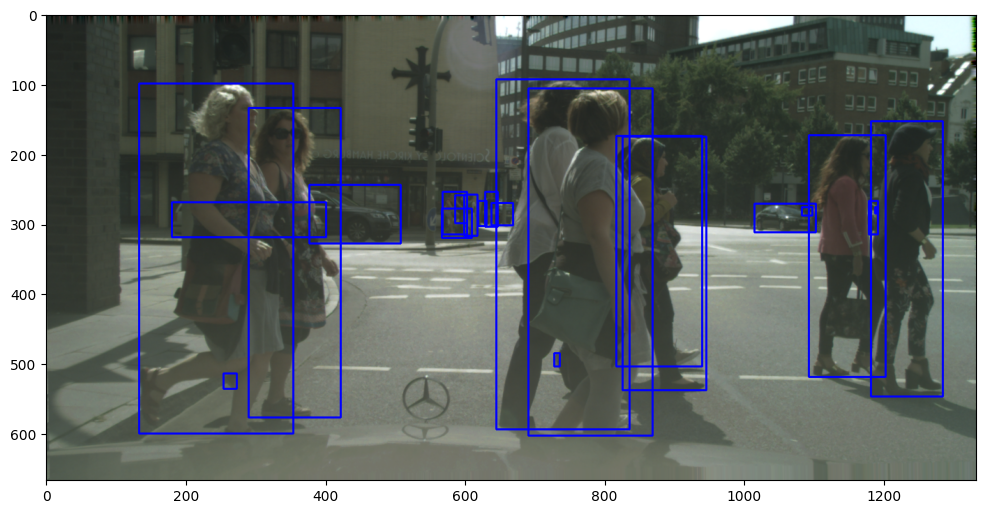

In [11]:
gt_boxes = first_input['instances'].gt_boxes.tensor.to(torch.int64).numpy()

import cv2

image_with_box = image.copy()
for gt_box in gt_boxes:
    image_with_box = cv2.rectangle(image_with_box, (gt_box[0], gt_box[1]),
                        (gt_box[2], gt_box[3]),
                        (0, 0, 255), 2, 1)

fig = plt.figure(figsize=(12, 12))
plt.imshow(image_with_box)

In [12]:
type(first_input['instances'].gt_masks)

detectron2.structures.masks.PolygonMasks

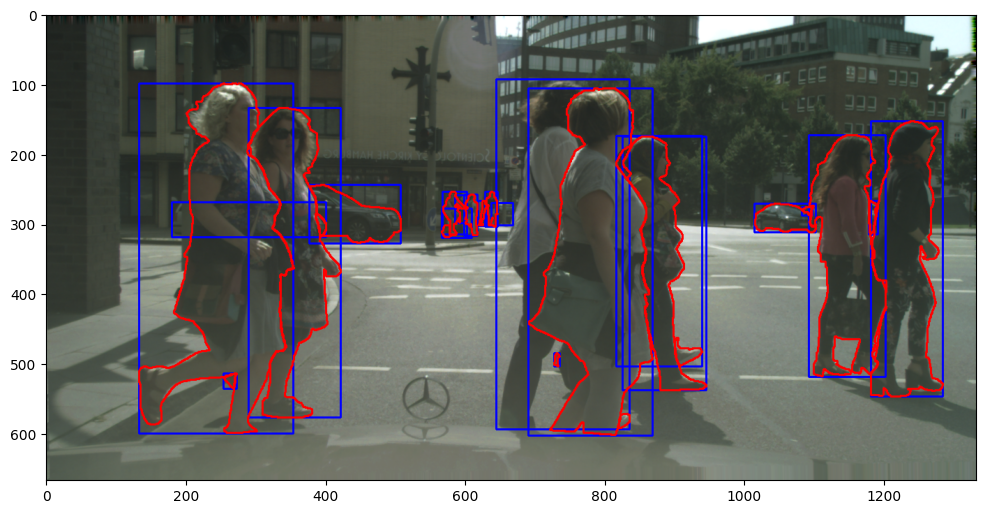

In [13]:
polygons = first_input['instances'].gt_masks

image_with_mask = image_with_box.copy()
for polygon in polygons:
    polygon = polygon[0].astype(np.int32)
    cv2.drawContours(image_with_mask, [polygon.reshape(-1, 2)], 0, (255, 0, 0), 2)

fig = plt.figure(figsize=(12, 12))
plt.imshow(image_with_mask)

In [14]:
from detectron2.structures.masks import PolygonMasks, BitMasks

In [15]:
bit_masks = BitMasks.from_polygon_masks(polygons.polygons, height=image.shape[0], width=image.shape[1])

In [16]:
mask = np.zeros(bit_masks.tensor.shape[1:])

for i in range(bit_masks.tensor.shape[0]):
    mask = np.logical_or(mask, bit_masks.tensor[i])

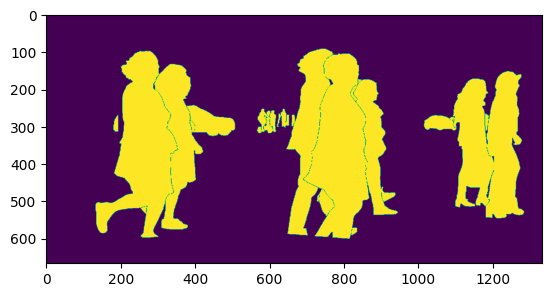

In [17]:
plt.imshow(mask)

# Proposal Generator

In [10]:
import torch

H = W = 2048
stride = 16
num_anchors = 15
N = 2


anchors = torch.rand(((H // stride) * (W // stride) * num_anchors, 4))

In [11]:
anchors.unsqueeze(0).expand(N, -1, -1).reshape(-1, 4).shape

torch.Size([491520, 4])

In [12]:
(2048 // 16) * (2048 // 16) * 15 * 2

491520

In [13]:
from detectron2.modeling.box_regression import Box2BoxTransform

In [14]:
box_transform = Box2BoxTransform(weights=[1.0, 1.0, 1.0, 1.0])

In [15]:
R = (H // stride) * (W // stride) * num_anchors

pred_anchor_deltas_i = torch.rand((N * R), 4)
anchors_i = torch.rand((N * R), 4)

proposals_i = box_transform.apply_deltas(pred_anchor_deltas_i, anchors_i)

In [16]:
proposals_i.view(N, -1, 4).shape

torch.Size([2, 245760, 4])

In [17]:
rpn = mask_rcnn.proposal_generator
backbone = mask_rcnn.backbone

In [18]:
images = mask_rcnn.preprocess_image(batch)
features = backbone(images.tensor)
gt_instances = [x['instances'] for x in batch]

In [19]:
rpn.training = False
rpn.positive_fraction = 0.5


proposals, proposal_losses = rpn(images, features, gt_instances)

/Users/giakhang/miniconda3/envs/hope_to_public_net/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025539291/work/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [20]:
images.image_sizes

[(640, 1280), (667, 1333)]

In [21]:
features['res4'].shape

torch.Size([2, 1024, 42, 84])

In [23]:
proposals[0].__len__()

1000

# ROI Head

In [27]:
roi_heads = mask_rcnn.roi_heads

In [28]:
from detectron2.utils.events import EventStorage

# Example usage:
# Inside your training loop or evaluation loop
with EventStorage() as storage:
    # Your code here
    # Access the event storage within this context

    test_proposals = roi_heads.label_and_sample_proposals(proposals, gt_instances)

In [29]:
test_proposals[0].__len__()

512

In [30]:
gt_instances[0].get_fields().keys()

dict_keys(['gt_boxes', 'gt_classes', 'gt_masks'])

In [31]:
test_proposals[0].get_fields().keys()

dict_keys(['proposal_boxes', 'objectness_logits', 'gt_classes', 'gt_boxes', 'gt_masks'])

In [32]:
test_proposals[0]

Instances(num_instances=512, image_height=640, image_width=1280, fields=[proposal_boxes: Boxes(tensor([[ 946.0000,  251.0000, 1050.0000,  290.0000],
        [ 590.4047,  208.1256,  685.2508,  356.5351],
        [ 944.0000,  190.0000, 1035.0000,  400.0000],
        ...,
        [ 568.7186,    0.0000,  707.1929,  146.3948],
        [  12.6102,  415.7314,  238.5904,  512.1940],
        [1006.4811,  363.1638, 1141.0697,  497.6807]])), objectness_logits: tensor([23.0259,  0.4715, 23.0259, 23.0259,  0.4402, 23.0259,  0.4047,  0.6063,
        23.0259, 23.0259,  0.3997, 23.0259, 23.0259,  0.4805, 23.0259,  0.4068,
        23.0259,  0.3945, 23.0259, 23.0259, 23.0259,  0.6047, 23.0259, 23.0259,
        23.0259,  0.4861, 23.0259, 23.0259,  0.6463, 23.0259, 23.0259, 23.0259,
         0.4602,  0.4058,  0.5239,  0.4100,  0.3913,  0.5188,  0.4053,  0.4502,
         0.5460,  0.4189,  0.4148,  0.4944,  0.5007,  0.4669,  0.4703,  0.4105,
         0.5321,  0.4097,  0.4090,  0.4832,  0.4115,  0.4716,  0.4

In [33]:
test_proposals[0].proposal_boxes.tensor.shape

torch.Size([512, 4])

In [34]:
test_proposals[0].proposal_boxes

Boxes(tensor([[ 946.0000,  251.0000, 1050.0000,  290.0000],
        [ 590.4047,  208.1256,  685.2508,  356.5351],
        [ 944.0000,  190.0000, 1035.0000,  400.0000],
        ...,
        [ 568.7186,    0.0000,  707.1929,  146.3948],
        [  12.6102,  415.7314,  238.5904,  512.1940],
        [1006.4811,  363.1638, 1141.0697,  497.6807]]))

## Pooler

In [35]:
pooler = roi_heads.pooler

In [36]:
len(pooler.level_poolers)

1

In [37]:
proposal_boxes = [x.proposal_boxes for x in test_proposals]

In [38]:
import torch

boxes = torch.cat([x.tensor for x in proposal_boxes], dim=0)

In [39]:
boxes.shape

torch.Size([1024, 4])

In [40]:
from detectron2.layers import shapes_to_tensor

sizes = shapes_to_tensor([x.__len__() for x in boxes])

In [41]:
sizes.shape

torch.Size([1024])

In [42]:
from detectron2.modeling.poolers import _convert_boxes_to_pooler_format, convert_boxes_to_pooler_format

In [43]:
# A tensor of shape (M, 5), where M is the total #boxes aggregated
# over all N batch images. The 5 columns are (batch index, x0, y0, x1, y1),
# where batch index is the index [0, N) indentifying which batch image
# the box with corners at (x0, y0, x1, y1) comes from.

pooler_fmt_boxes = convert_boxes_to_pooler_format(proposal_boxes)  

In [44]:
pooler_fmt_boxes

tensor([[0.0000e+00, 9.4600e+02, 2.5100e+02, 1.0500e+03, 2.9000e+02],
        [0.0000e+00, 5.9040e+02, 2.0813e+02, 6.8525e+02, 3.5654e+02],
        [0.0000e+00, 9.4400e+02, 1.9000e+02, 1.0350e+03, 4.0000e+02],
        ...,
        [1.0000e+00, 9.3785e+02, 1.1614e+02, 1.1210e+03, 2.0256e+02],
        [1.0000e+00, 7.2552e+02, 1.3147e+02, 8.6282e+02, 2.3076e+02],
        [1.0000e+00, 5.8550e+02, 3.5690e+02, 7.6493e+02, 4.5605e+02]])

In [45]:
box_features = pooler.level_poolers[0](features['res4'], pooler_fmt_boxes)

In [46]:
box_features.shape

torch.Size([1024, 1024, 14, 14])

In [47]:
features['res4'].shape

torch.Size([2, 1024, 42, 84])

In [48]:
pooler_fmt_boxes

tensor([[0.0000e+00, 9.4600e+02, 2.5100e+02, 1.0500e+03, 2.9000e+02],
        [0.0000e+00, 5.9040e+02, 2.0813e+02, 6.8525e+02, 3.5654e+02],
        [0.0000e+00, 9.4400e+02, 1.9000e+02, 1.0350e+03, 4.0000e+02],
        ...,
        [1.0000e+00, 9.3785e+02, 1.1614e+02, 1.1210e+03, 2.0256e+02],
        [1.0000e+00, 7.2552e+02, 1.3147e+02, 8.6282e+02, 2.3076e+02],
        [1.0000e+00, 5.8550e+02, 3.5690e+02, 7.6493e+02, 4.5605e+02]])

In [49]:
pooler_fmt_boxes.shape

torch.Size([1024, 5])

In [50]:
proposal_boxes

[Boxes(tensor([[ 946.0000,  251.0000, 1050.0000,  290.0000],
         [ 590.4047,  208.1256,  685.2508,  356.5351],
         [ 944.0000,  190.0000, 1035.0000,  400.0000],
         ...,
         [ 568.7186,    0.0000,  707.1929,  146.3948],
         [  12.6102,  415.7314,  238.5904,  512.1940],
         [1006.4811,  363.1638, 1141.0697,  497.6807]])),
 Boxes(tensor([[ 108.1753,  293.0206,  250.4272,  387.0712],
         [ 623.0000,  251.0000,  659.0000,  312.0000],
         [ 704.0000,  255.0000,  719.0000,  286.0000],
         ...,
         [ 937.8489,  116.1398, 1121.0271,  202.5629],
         [ 725.5175,  131.4737,  862.8221,  230.7590],
         [ 585.5027,  356.9049,  764.9258,  456.0528]]))]

In [51]:
roi_heads.pooler.level_poolers[0].spatial_scale  # spatial_scale = 0.0625 = 1 / 16 (16 = stride of res4)

0.0625

In [52]:
features['res4'].shape

torch.Size([2, 1024, 42, 84])

In [53]:
box_features.shape

torch.Size([1024, 1024, 14, 14])

In [54]:
x = roi_heads.res5(box_features)

In [55]:
x.shape

torch.Size([1024, 2048, 7, 7])

## Mask Head

### Training

In [149]:
proposals_per_image = test_proposals[0]

In [150]:
gt_classes = proposals_per_image.gt_classes
fg_selection_mask = (gt_classes != -1) & (gt_classes != 80)

In [151]:
box_features.shape

torch.Size([1024, 1024, 14, 14])

In [152]:
fg_selection_masks = []

for proposals_per_image in test_proposals:
    gt_classes = proposals_per_image.gt_classes
    fg_selection_mask = (gt_classes != -1) & (gt_classes != 80)
    fg_selection_masks.append(fg_selection_mask)

In [163]:
mask_features = x[torch.cat(fg_selection_masks, dim=0)]
print('Mask feature shape = ', mask_features.shape)
print('#fg_proposals image 1 = ', fg_selection_masks[0].numpy().sum())
print('#fg_proposals image 2 = ', fg_selection_masks[1].numpy().sum())
print('Total #fg_proposals over batch = ', torch.cat(fg_selection_masks, dim=0).numpy().sum())

Mask feature shape =  torch.Size([44, 2048, 7, 7])
#fg_proposals image 1 =  32
#fg_proposals image 2 =  12
Total #fg_proposals over batch =  44


In [79]:
mask_head = roi_heads.mask_head

In [243]:
pred_mask_logits = mask_head.layers(mask_features)
pred_mask_logits.shape

torch.Size([44, 80, 14, 14])

In [171]:
proposals_per_image = test_proposals[0]
fg_selection_mask = fg_selection_masks[0]

fg_proposals_per_image = proposals_per_image[fg_selection_mask]

In [180]:
gt_classes_per_image = fg_proposals_per_image.gt_classes.to(dtype=torch.int64)
gt_masks_per_image_polygons = fg_proposals_per_image.gt_masks


In [182]:
gt_masks_per_image = gt_masks_per_image_polygons.crop_and_resize(fg_proposals_per_image.proposal_boxes.tensor,
                                                        mask_features_out.shape[2])
gt_masks_per_image.shape

torch.Size([32, 14, 14])

In [273]:
gt_classes, gt_masks = [], []

for proposal, fg_selection_mask in zip(test_proposals, fg_selection_masks):
    gt_classes_per_image = proposal[fg_selection_mask].gt_classes.to(dtype=torch.int64)
    gt_masks_per_image_polygon = proposal[fg_selection_mask].gt_masks
    gt_masks_per_image = gt_masks_per_image_polygon.crop_and_resize(proposal[fg_selection_mask].proposal_boxes.tensor,
                                                                    pred_mask_logits.shape[2])
    gt_classes.append(gt_classes_per_image)
    gt_masks.append(gt_masks_per_image)

In [274]:
from detectron2.layers import cat

gt_masks = cat(gt_masks, dim=0)
gt_classes = cat(gt_classes, dim=0)

In [202]:
gt_masks.shape

torch.Size([44, 14, 14])

In [205]:
gt_classes.shape

torch.Size([44])

In [206]:
total_num_masks = pred_mask_logits.size(0)
indices = torch.arange(total_num_masks)

In [244]:
choose_pred_mask_logits = pred_mask_logits[indices, gt_classes]

In [246]:
choose_pred_mask_logits.shape

torch.Size([44, 14, 14])

In [275]:
gt_masks_bool = gt_masks
gt_masks = gt_masks.to(dtype=torch.float32)

In [276]:
gt_masks_bool.shape

torch.Size([44, 14, 14])

In [332]:
print('gt_masks : shape = ', gt_masks.shape)
print('pred_masks_logits: shape = ', choose_pred_mask_logits.shape)

gt_masks : shape =  torch.Size([44, 14, 14])
pred_masks_logits: shape =  torch.Size([44, 14, 14])


In [252]:
mask_loss = torch.nn.functional.binary_cross_entropy_with_logits(gt_masks, choose_pred_mask_logits, reduction='mean')

In [253]:
mask_loss

tensor(0.9635, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [294]:
mask_incorrect = (choose_pred_mask_logits > 0.0) != gt_masks_bool
mask_accuracy = 1 - (mask_incorrect.sum().item() / max(mask_incorrect.numel(), 1.0))
num_positive = gt_masks_bool.sum().item()
false_positive = (mask_incorrect & ~gt_masks_bool).sum().item() / max(gt_masks_bool.numel() - num_positive, 1.0)
false_negative = (mask_incorrect & gt_masks_bool).sum().item() / max(num_positive, 1.0)

In [317]:
print('mask accuracy = {:.2f}%'.format(mask_accuracy * 100))
print('false positive = {:.2f}%'.format(false_positive * 100))
print('false negative = {:.2f}%'.format(false_negative * 100))

mask accuracy = 45.67%
false positive = 78.85%
false negative = 23.33%


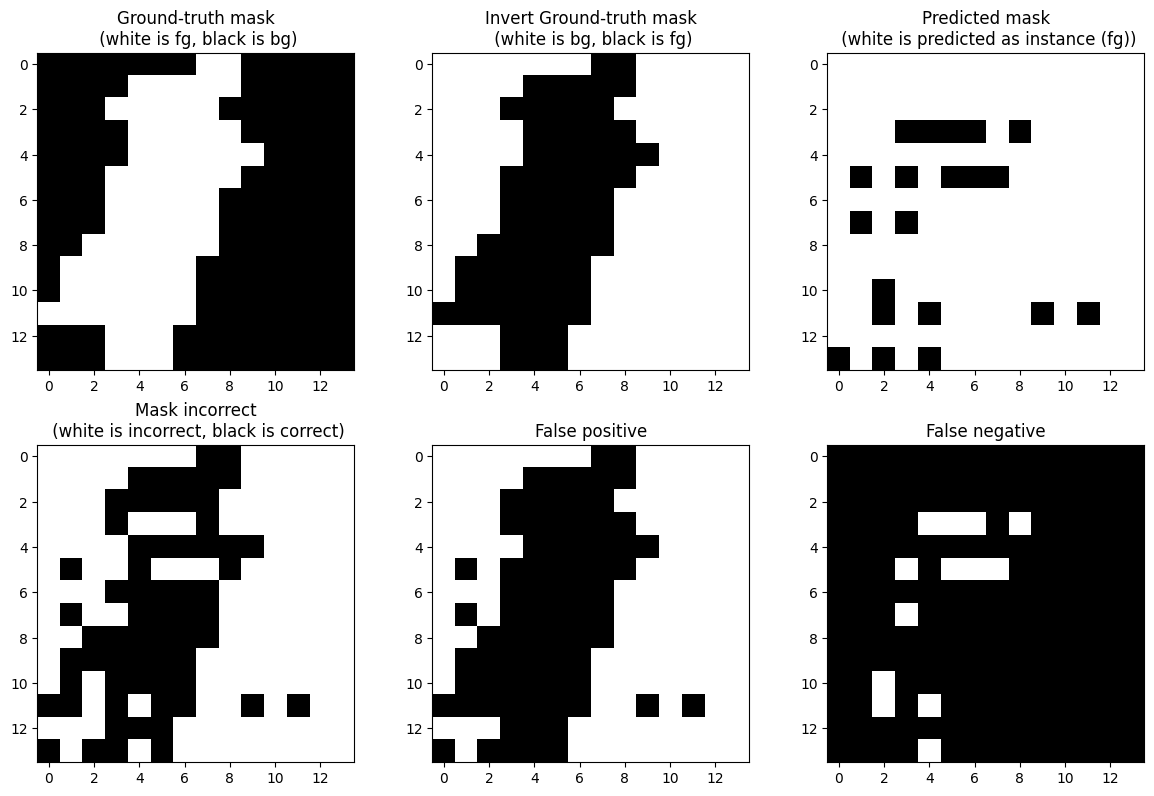

In [311]:
import matplotlib.pyplot as plt
import numpy as np


# Creating a figure and subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Plotting data on each subplot
axs[0, 0].imshow(gt_masks_bool[0], cmap='gray')
axs[0, 0].set_title('Ground-truth mask\n (white is fg, black is bg)')

axs[0, 1].imshow(~gt_masks_bool[0], cmap='gray')
axs[0, 1].set_title('Invert Ground-truth mask\n (white is bg, black is fg)')

axs[0, 2].imshow(choose_pred_mask_logits[0] > 0.0, cmap='gray')
axs[0, 2].set_title('Predicted mask\n (white is predicted as instance (fg))')

axs[1, 0].imshow(mask_incorrect[0], cmap='gray')
axs[1, 0].set_title('Mask incorrect\n (white is incorrect, black is correct)')

axs[1, 1].imshow((mask_incorrect & ~gt_masks_bool)[0], cmap='gray')
axs[1, 1].set_title('False positive')

axs[1, 2].imshow((mask_incorrect & gt_masks_bool)[0], cmap='gray')
axs[1, 2].set_title('False negative')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

### Inference

In [56]:
fg_selection_masks = []

for proposals_per_image in test_proposals:
    gt_classes = proposals_per_image.gt_classes
    fg_selection_mask = (gt_classes != -1) & (gt_classes != 80)
    fg_selection_masks.append(fg_selection_mask)

In [57]:
mask_features = x[torch.cat(fg_selection_masks, dim=0)]
print('Mask feature shape = ', mask_features.shape)
print('#fg_proposals image 1 = ', fg_selection_masks[0].numpy().sum())
print('#fg_proposals image 2 = ', fg_selection_masks[1].numpy().sum())
print('Total #fg_proposals over batch = ', torch.cat(fg_selection_masks, dim=0).numpy().sum())

Mask feature shape =  torch.Size([47, 2048, 7, 7])
#fg_proposals image 1 =  32
#fg_proposals image 2 =  15
Total #fg_proposals over batch =  47


In [83]:
gt_classes, gt_masks = [], []

for proposal, fg_selection_mask in zip(test_proposals, fg_selection_masks):
    gt_classes_per_image = proposal[fg_selection_mask].gt_classes.to(dtype=torch.int64)
    gt_masks_per_image_polygon = proposal[fg_selection_mask].gt_masks
    gt_masks_per_image = gt_masks_per_image_polygon.crop_and_resize(proposal[fg_selection_mask].proposal_boxes.tensor,
                                                                    pred_mask_logits.shape[2])
    gt_classes.append(gt_classes_per_image)
    gt_masks.append(gt_masks_per_image)

In [58]:
mask_head = roi_heads.mask_head
pred_mask_logits = mask_head.layers(mask_features)
pred_mask_logits.shape

torch.Size([47, 80, 14, 14])

In [67]:
num_masks = pred_mask_logits.shape[0]

In [84]:
from detectron2.layers import cat

# The correct version is that trying to get the `pred_classes` in `gt_instances`
# but for now, we dont have that field, so get the `gt_classes` instead
class_pred = torch.cat(gt_classes, dim=0)
indices = torch.arange(num_masks)

In [104]:
mask_probs_pred = pred_mask_logits[indices, class_pred]

In [105]:
mask_probs_pred = mask_probs_pred[:, None].sigmoid()

In [101]:
num_boxes_per_image = [len(proposal[fg_selection_masks[i]]) for (i, proposal) in enumerate(test_proposals)]

In [106]:
mask_probs_pred = mask_probs_pred.split(num_boxes_per_image, dim=0)

In [108]:
mask_probs_pred[0].shape

torch.Size([32, 1, 14, 14])

In [115]:
mask_probs_pred[1].shape

torch.Size([15, 1, 14, 14])

In [144]:
for i, (prob, instances) in enumerate(zip(mask_probs_pred, test_proposals)):
    instances = instances[fg_selection_masks[i]]
    instances.pred_masks = prob
    instances.pred_boxes = instances.gt_boxes
    instances.pred_classes = instances.gt_classes
    test_proposals[i] = instances
    

### postprocess after inferring

In [197]:
from detectron2.structures import ROIMasks

isinstance(test_proposals[0].gt_masks, ROIMasks)

False

In [198]:
roi_masks = test_proposals[0].pred_masks

In [206]:
roi_masks = ROIMasks(test_proposals[0].pred_masks[:, 0, :, :])

In [210]:
roi_masks.tensor.shape

torch.Size([32, 14, 14])

In [213]:
from detectron2.structures import BitMasks

In [272]:
bitmasks = BitMasks.from_polygon_masks(test_proposals[0].gt_masks.polygons, 
                                       height=test_proposals[0].image_size[0], 
                                       width=test_proposals[0].image_size[1])
roi_align = bitmasks.crop_and_resize(test_proposals[0].gt_boxes.tensor, 14)

In [273]:
mask = bitmasks.tensor[4]

In [275]:
indices = mask.nonzero()
x1, y1 = indices[:, 0].min().item(), indices[:, 1].min().item()
x2, y2 = indices[:, 0].max().item(), indices[:, 1].max().item()

mask = mask[x1:x2, y1:y2]

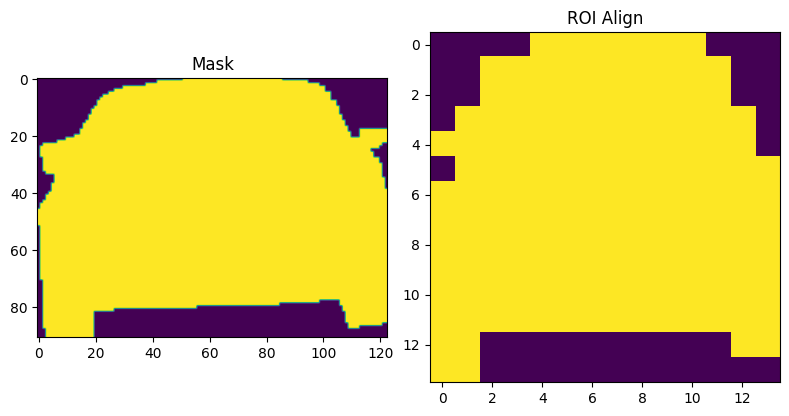

In [278]:
import matplotlib.pyplot as plt
import numpy as np

# Creating a figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

# Plotting data on each subplot
axs[0].imshow(mask)
axs[0].set_title('Mask')

axs[1].imshow(roi_align[4])
axs[1].set_title('ROI Align')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [281]:
from detectron2.layers.mask_ops import paste_masks_in_image

In [283]:
pred_masks = paste_masks_in_image(roi_align, test_proposals[0].gt_boxes.tensor, test_proposals[0].image_size)

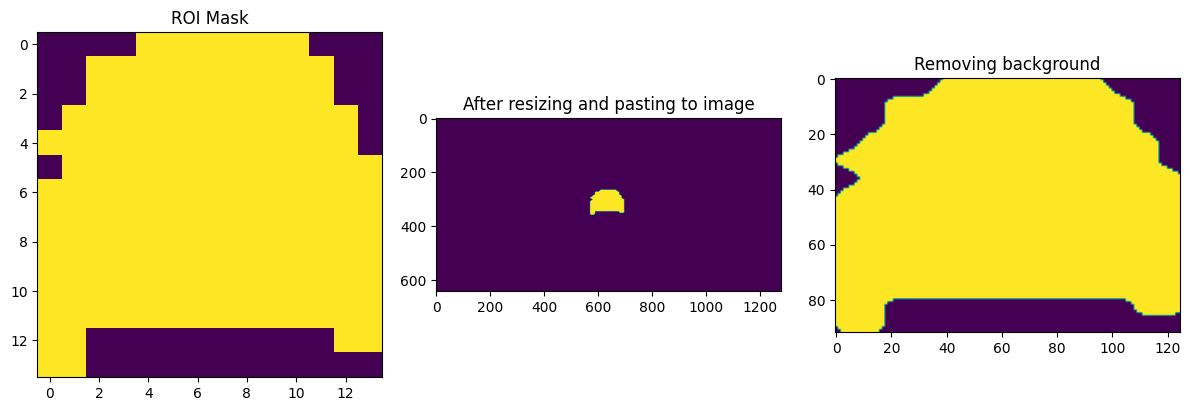

In [295]:
import matplotlib.pyplot as plt
import numpy as np

# Creating a figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 8))

# Plotting data on each subplot
axs[0].imshow(roi_align[4])
axs[0].set_title('ROI Mask')

axs[1].imshow(pred_masks[4])
axs[1].set_title('After resizing and pasting to image')

indices = pred_masks[4].nonzero()
x1, y1 = indices[:, 0].min().item(), indices[:, 1].min().item()
x2, y2 = indices[:, 0].max().item(), indices[:, 1].max().item()
zoom_mask = pred_masks[4][x1:x2, y1:y2]

axs[2].imshow(zoom_mask)
axs[2].set_title('Removing background')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()